In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

# data1

In [7]:
data1=pd.read_excel('./data/data1.xlsx')
data1.shape

(197, 2)

In [8]:
data1

,period,constration
0,1,17.0
1,2,16.6
2,3,16.3
3,4,16.1
4,5,17.1
...,...,...
192,193,17.6
193,194,17.8
194,195,17.7
195,196,17.2


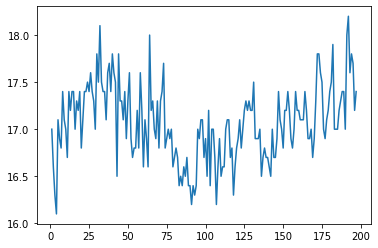

In [14]:
plt.plot(data1['period'],data1['constration'])
# 정상성은 만족하는 것으로 보인다.
#차분은 진행 x
#주기성은 없어보인다.

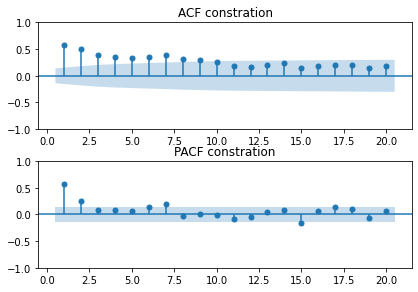

In [19]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
fig.tight_layout()

sgt.plot_acf(data1['constration'], lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF constration")


sgt.plot_pacf(data1['constration'], lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF constration")

plt.show()

#ACF 가 천천히 감소한다. -> 차분을 수행한다.

#PACF : zero after lag 2


1     -0.4
2     -0.3
3     -0.2
4      1.0
5     -0.2
      ... 
192   -0.6
193    0.2
194   -0.1
195   -0.5
196    0.2
Name: constration, Length: 196, dtype: float64

In [23]:
data1_diff=data1['constration'].diff() # 판다스의 diff 메소드를 이용해 차분하는 방법

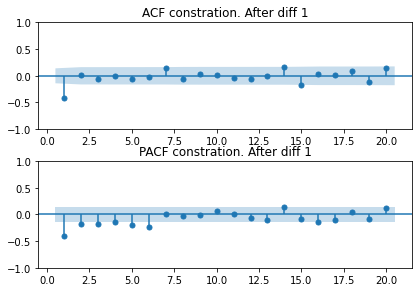

In [28]:
# acf, pacf
import statsmodels.graphics.tsaplots as sgt 

## Close
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
fig.tight_layout()

sgt.plot_acf(data1_diff.dropna(), lags = 20, zero = False, ax=ax1)
ax1.set_title("ACF constration. After diff 1")


sgt.plot_pacf(data1_diff.dropna(), lags = 20, zero = False, method = ('ols'), ax=ax2)
ax2.set_title("PACF constration. After diff 1")

plt.show()

#ACF : zero after lag 1

#PACF : zero after lag 1. sinusoidal decay


# MA(1) 모형으로 추정된다.